In [68]:
import pandas as pd
import numpy as np
import os
import FinanceDataReader as fdr
import torch
import torchvision
from pykrx import stock
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta

In [69]:
torch.manual_seed(0) # 랜덤 시드 처리
device = 'cuda' if torch.cuda.is_available() else 'cpu' # GPU를 활용 가능하면 GPU로 학습함
print("Using", device)

Using cuda


In [70]:
class Net(torch.nn.Module): # Network 구조 - RNN 통과 이후에 linear layer들을 적당히 통과시켜서 구현함
    def __init__(self, input_dim, hidden_dim, output_dim, layers_rnn, layers_fc):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers_rnn, batch_first=True)
        fclist = []
        for i in range(layers_fc - 1): # layers_fc should be over 1
            fclist.append(torch.nn.Linear(hidden_dim, hidden_dim, bias=True))
            fclist.append(torch.nn.ReLU())
        
        self.fc_seq = torch.nn.Sequential(*fclist)
        self.fc_last = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc_seq(x)
        x = self.fc_last(x)
        x = x[:, [-1], :].view(-1, output_seq_length)
        return x

In [71]:
class newNet(torch.nn.Module): # 새 network FC - RNN - FC
    def __init__(self, input_dim, hidden_dim, output_dim, layers_rnn, layers_fc):
        super(newNet, self).__init__()
        fcinlist = []
        fcinlist.append(torch.nn.Linear(input_dim, hidden_dim, bias=True))
        for i in range(layers_fc - 1): # layers_fc should be over 1
            fcinlist.append(torch.nn.Linear(hidden_dim, hidden_dim, bias=True))
            fcinlist.append(torch.nn.ReLU())
        self.fc_in = torch.nn.Sequential(*fcinlist)
        self.rnn = torch.nn.LSTM(hidden_dim, hidden_dim, num_layers=layers_rnn, batch_first=True)
        fclist = []
        for i in range(layers_fc - 1): # layers_fc should be over 1
            fclist.append(torch.nn.Linear(hidden_dim, hidden_dim, bias=True))
            fclist.append(torch.nn.ReLU())
        
        self.fc_seq = torch.nn.Sequential(*fclist)
        self.fc_last = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x = self.fc_in(x)
        x, _status = self.rnn(x)
        x = self.fc_seq(x)
        x = self.fc_last(x)
        x = x[:, [-1], :].view(-1, output_seq_length)
        return x

In [72]:
seq_length = 15 # 이전 15일의 데이터를 가지고 예측함
stock_num = 10 # 10종목의 주식을 가지고 학습, 예측함
learning_rate = 1e-5 # 학습률(아마 이미 적당한 값인 것 같음)
output_seq_length = 5 # 이후 5일의 데이터를 예측
test_len = 1 # 테스트 데이터의 길이를 1으로 고정

start_year = '2019'
end_year = '2022'

start_date = start_year + '0101'
end_date = end_year + '0527'  # 2020 01월 01일 ~ 2022년 5월 1일 데이터 load
start_date_y = start_year + '-01-01'
end_date_y = end_year + '-05-27'

In [73]:
def build_dataset(time_series, seq_length, output_seq_length): # time series로 input을 받고, seq_length만큼 잘라서 입력 데이터 구성,
                                                               # output_seq_length만큼 잘라서 출력 데이터 구성
    dataX = []
    dataY = []
    for i in range(0, 1 + len(time_series) - seq_length - output_seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length:i + seq_length + output_seq_length, [0]]
        dataX.append(_x)
        dataY.append(_y)
    
    return np.array(dataX), np.array(dataY)

In [74]:
def minmax_scaler(data): # 데이터의 값들을 0~1 사이의 값으로 조정함 -> Normalization을 거치면 학습이 훨씬 잘 되는 것은 이미 확인하였음
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [75]:
def data_load(stock_dict): # stock_dict로 pandas dataframe 형식의 데이터를 받아
                           # train, test data를 만들어 냄, 이 때 train, test는 0~1사이의 값으로 scale된 것임
                           # train_non_scaled가 scale 되지 않은 데이터 -> 이 데이터는 테스트시에만 사용
    trainX = []
    testX = []
    trainY = []
    testY = []
    testX_non_scaled = []
    testY_non_scaled = []
    for stock_name in stock_dict:
        input_data = stock_dict[stock_name]['df']
        output_data = stock_dict[stock_name]['target_list']
        input_data = input_data.values[:, 1:].astype(np.float64)
        print(input_data.shape)
        
        #train_size = int(len(input_data) * train_portion)
        train_tmp = input_data[0:len(input_data) - output_seq_length]
        test_tmp = input_data[len(input_data) - seq_length - output_seq_length:]

        testX_non_scaled_tmp, testY_non_scaled_tmp = build_dataset(test_tmp, seq_length, output_seq_length)

        train_tmp = minmax_scaler(train_tmp)
        test_tmp = minmax_scaler(test_tmp)

        trainX_tmp, trainY_tmp = build_dataset(train_tmp, seq_length, output_seq_length)
        testX_tmp, testY_tmp = build_dataset(test_tmp, seq_length, output_seq_length)
        
        trainX_tmp = torch.FloatTensor(trainX_tmp).to(device)
        testX_tmp = torch.FloatTensor(testX_tmp).to(device)
        testX_non_scaled_tmp = torch.FloatTensor(testX_non_scaled_tmp).to(device)
        trainY_tmp = torch.FloatTensor(trainY_tmp).to(device)
        testY_tmp = torch.FloatTensor(testY_tmp).to(device)
        testY_non_scaled_tmp = torch.FloatTensor(testY_non_scaled_tmp).to(device)

        trainX.append(trainX_tmp)
        trainY.append(trainY_tmp.view(-1, output_seq_length))
        testX.append(testX_tmp)
        testY.append(testY_tmp.view(-1, output_seq_length))
        testX_non_scaled.append(testX_non_scaled_tmp)
        testY_non_scaled.append(testY_non_scaled_tmp.view(-1, output_seq_length))
    return trainX, trainY, testX, testY, testX_non_scaled, testY_non_scaled

In [76]:
# 이곳부터는 Feature들을 계산해 내는 과정 - 여기는 1등팀의 소스를 거의 복사함
#
# 참고 :
# 코드 -
# https://dacon.io/competitions/official/235857/codeshare/3817?page=3&dtype=recent
#
# 발표자료 -
# https://dacon.io/competitions/official/235857/codeshare/4095?page=2&dtype=recent

# 종목 코드 로드
stock_list = pd.read_csv("open/Stock_List.csv")
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x: str(x).zfill(6))


#2-- 종목명을 key로 dict(=stock_dict) 생성
stock_list.set_index("종목명", inplace=True)
selected_codes = stock_list.index.tolist()
stock_list = stock_list.loc[selected_codes]["종목코드"]
stock_dic = dict.fromkeys(selected_codes) 


#3-- 날짜 지정 - 편의를 위해 맨 위로 옯김



#4-- Original data loading
for stock_name, stock_code in tqdm(stock_list.items()):
    print("=====", stock_name, "=====")
    business_days = pd.DataFrame(pd.date_range(start_date, end_date, freq='B'), columns=['Date'])

    # 종목 주가 데이터 로드
    # 기간&외국인 합계 없는 경우
    stock_dic[stock_name] = dict.fromkeys(["df", "target_list"])
    stock_df = stock.get_market_ohlcv_by_date(start_date, end_date, stock_code).reset_index()
    kospi_df = stock.get_index_ohlcv_by_date(start_date, end_date, "1001")[["종가"]].reset_index()

    stock_df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
    kospi_df.columns = ["Date", "kospi"]
    business_days = business_days[business_days["Date"] >= stock_df["Date"][0]]

    # 영업일과 주가 정보를 outer 조인
    train_x = pd.merge(business_days, stock_df, how='left', on="Date")
    train_x = pd.merge(train_x, kospi_df, how='left', on="Date")

    # 앞의 일자로 nan값 forward fill
    train_x.iloc[:, 1:] = train_x.iloc[:, 1:].ffill(axis=0)
    # 첫 날이 na 일 가능성이 있으므로 backward fill 수행
    train_x.iloc[:, 1:] = train_x.iloc[:, 1:].bfill(axis=0)
    stock_dic[stock_name]["df"] = train_x.copy()


0it [00:00, ?it/s]

===== 삼성전자 =====


1it [00:00,  3.20it/s]

===== SK하이닉스 =====


2it [00:00,  4.03it/s]

===== NAVER =====


4it [00:00,  4.54it/s]

===== 카카오 =====
===== 삼성바이오로직스 =====


6it [00:01,  4.65it/s]

===== 삼성전자우 =====
===== LG화학 =====


7it [00:01,  4.64it/s]

===== 삼성SDI =====


8it [00:01,  4.71it/s]

===== 현대차 =====


9it [00:02,  4.46it/s]

===== 셀트리온 =====


10it [00:02,  4.47it/s]


In [77]:
# 환율 관련 데이터를 불러오는 것으로 보임

forex_index_data = yf.download(["USDKRW=X", "USDAUD=X", "USDJPY=X", "EURUSD=X", "CNY=X", "^GSPC", "^DJI", "^IXIC", "^STOXX50E",
                                "^SOX",  "000001.SS", "000300.SS", "MME=F", "^TNX"], start=start_date_y, end=end_date_y, rounding=True)

tmp_forex_index = forex_index_data["Close"]
tmp_forex_index.index = pd.to_datetime(tmp_forex_index.index)
tmp_forex_index = tmp_forex_index[(tmp_forex_index.index >= pd.to_datetime(start_date_y)) & (tmp_forex_index.index <= pd.to_datetime(end_date_y))]
tmp_forex_index.columns = ["sse_composite_index", "csi300_index", "usdtocny", "eurtousd", "msci_emerging", "usdtoaud", "usdtojpy", "usdtokrw",
                           "dow", "snp500", "nasdaq", "semicon_index", "euro50", "us10y_tsy"]

tmp_forex_index.reset_index(drop=False, inplace=True)

[*********************100%***********************]  14 of 14 completed


In [78]:
# 1등팀이 사용한 함수들 중에서 올라오지 않은 함수가 2개 있었는데,
# 하나가 stochastic 함수, 나머지 하나가 week_of_month였음
# week_of_month는 비교적 이해가 직관적으로 쉬워서 같은 역할을 하는 함수를 인터넷에서 긁어옴
# 나중에 직접 만드는 것도 괜찮을 정도로 내용이 쉽기는 한듯함

from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [79]:
# 여러 Feature들을 계산하는 과정
# 앞에서 말했듯이 함수가 서술되어있지 않은 관계로 stochastic 부분은 데이터에서 뺐음
# 또, RNN을 사용하여 학습시키기 때문에 과거 데이터 부분을 사용하지 않았음
# 이동평균 부분도 정확하게 코드 이해가 되면 빼야하는 Feature인지 고민해 볼 여지가 있음
# 

# ===== feature engineering =====
non_stock = []
corr_list = []
timeunit_gap_forviz = 1
metric_days = 14
cat_vars = []
bin_vars = []
cat_vars.append("weekday")
cat_vars.append("weeknum")
bin_vars.append("mfi_signal")
num_pvalue_check = None
cat_pvalue_check = pd.Series(0, index=["weekday", "weeknum", "mfi_signal"])


for stock_name, stock_data in stock_dic.items():
    train_x = stock_data["df"].copy()

    # 1. 환율 및 관련 인덱스 feature 추가
    train_x = pd.merge(train_x, tmp_forex_index, how="left", on="Date")
    train_x = train_x.ffill() # 과거 일자로 forward fill 수행    
    train_x = train_x.bfill() # 첫 날이 nan 일 가능성이 있으므로 backward fill 수행


    # 2. 요일 및 주차 파생변수 추가
    train_x['weekday'] = train_x["Date"].apply(lambda x: x.weekday())
    train_x['weeknum'] = train_x["Date"].apply(lambda x: week_of_month(x))


    # 3. 거래대금 파생변수 추가
    train_x['trading_amount'] = train_x["Close"] * train_x["Volume"]

    # 4. 월별 주기성 특징을 잡기 위한 sin 및 cos 변환 파생변수 추가
    day_to_sec = 24 * 60 * 60
    month_to_sec = 20 * day_to_sec
    timestamp_s = train_x["Date"].apply(datetime.timestamp)
    timestamp_freq = round((timestamp_s / month_to_sec).diff(20)[20], 1)
    train_x['dayofmonth_freq_sin'] = np.sin((timestamp_s / month_to_sec) * ((2 * np.pi) / timestamp_freq))
    train_x['dayofmonth_freq_cos'] = np.cos((timestamp_s / month_to_sec) * ((2 * np.pi) / timestamp_freq))


    # 5. OBV 파생변수 추가
    # 매수 신호: obv > obv_ema
    # 매도 신호: obv < obv_ema
    obv = [0]
    for i in range(1, len(train_x.Close)):
        if train_x.Close[i] >= train_x.Close[i - 1]:
            obv.append(obv[-1] + train_x.Volume[i])
        elif train_x.Close[i] < train_x.Close[i - 1]:
            obv.append(obv[-1] - train_x.Volume[i])
    train_x['obv'] = obv
    train_x['obv'][0] = np.nan
    train_x['obv_ema'] = train_x['obv'].ewm(com=metric_days, min_periods=metric_days).mean()


    # 6. Stochastic 파생변수 추가
    # fast_d = moving average on fast_k
    # stochastic 관련 지식이 없는데 함수 구현 방법을 알려주지 않아서 넘김
    # train_x[["fast_k", "fast_d"]] = stochastic(train_x, n=metric_days)[["fast_k", "fast_d"]]


    # 7. MFI 파생변수 추가
    # MFI = 100 - (100 / 1 + MFR)
    # MFR = 14일간의 양의 MF / 14일간의 음의 MF
    # MF = 거래량 * (당일고가 + 당일저가 + 당일종가) / 3
    # MF 컬럼 만들기
    train_x["mf"] = train_x["Volume"] * ((train_x["High"]+train_x["Low"]+train_x["Close"]) / 3)
    # 양의 MF와 음의 MF 표기 컬럼 만들기
    p_n = []
    for i in range(len(train_x['mf'])):
        if i == 0 :
            p_n.append(np.nan)
        else:
            if train_x['mf'][i] >= train_x['mf'][i-1]:
                p_n.append('p')
            else:
                p_n.append('n')
    train_x['p_n'] = p_n
    # 14일간 양의 MF/ 14일간 음의 MF 계산하여 컬럼 만들기
    mfr = []
    for i in range(len(train_x['mf'])):
        if i < metric_days-1:
            mfr.append(np.nan)
        else:
            train_x_=train_x.iloc[(i-metric_days+1):i]
            a = (sum(train_x_['mf'][train_x['p_n'] == 'p']) + 1) / (sum(train_x_['mf'][train_x['p_n'] == 'n']) + 10)
            mfr.append(a)
    train_x['mfr'] = mfr
    # 최종 MFI 컬럼 만들기
    train_x['mfi'] = 100 - (100 / (1 + train_x['mfr']))
    train_x["mfi_signal"] = train_x['mfi'].apply(lambda x: 1 if x > 50 else 0) # 1 = buy, 0 = sell


    # 8. 이동평균 추가
    train_x["close_mv5"] = train_x["Close"].rolling(5, min_periods=5).mean()
    train_x["close_mv10"] = train_x["Close"].rolling(10, min_periods=10).mean()
    train_x["close_mv20"] = train_x["Close"].rolling(20, min_periods=20).mean()

    train_x["volume_mv5"] = train_x["Volume"].rolling(5, min_periods=5).mean()
    train_x["volume_mv10"] = train_x["Volume"].rolling(10, min_periods=10).mean()
    train_x["volume_mv20"] = train_x["Volume"].rolling(20, min_periods=20).mean()

    train_x["trading_amount_mv5"] = train_x["trading_amount"].rolling(5, min_periods=5).mean()
    train_x["trading_amount_mv10"] = train_x["trading_amount"].rolling(10, min_periods=10).mean()
    train_x["trading_amount_mv20"] = train_x["trading_amount"].rolling(20, min_periods=20).mean()

    train_x["kospi_mv5"] = train_x["kospi"].rolling(5, min_periods=5).mean()
    train_x["kospi_mv10"] = train_x["kospi"].rolling(10, min_periods=10).mean()
    train_x["kospi_mv20"] = train_x["kospi"].rolling(20, min_periods=20).mean()

    try:
        train_x["inst_mv5"] = train_x["inst"].rolling(5, min_periods=5).mean()
        train_x["inst_mv10"] = train_x["inst"].rolling(10, min_periods=10).mean()
        train_x["inst_mv20"] = train_x["inst"].rolling(20, min_periods=20).mean()

        # 기관 연속 순매수 일자 feature 생성
        cnt_consecutive = 0
        tmp_consecutive = []
        for i in train_x["inst"]:
            if i > 0:
                cnt_consecutive += 1
            else:
                cnt_consecutive = 0
            tmp_consecutive.append(cnt_consecutive)
        train_x["consec_inst"] = tmp_consecutive

        train_x["fore_mv5"] = train_x["fore"].rolling(5, min_periods=5).mean()
        train_x["fore_mv10"] = train_x["fore"].rolling(10, min_periods=10).mean()
        train_x["fore_mv20"] = train_x["fore"].rolling(20, min_periods=20).mean()

        # 외국인 연속 순매수 일자 feature 생성
        cnt_consecutive = 0
        tmp_consecutive = []
        for i in train_x["fore"]:
            if i > 0:
                cnt_consecutive += 1
            else:
                cnt_consecutive = 0
            tmp_consecutive.append(cnt_consecutive)
        train_x["consec_fore"] = tmp_consecutive
    except:
        pass


    # 9. 과거데이터 추가 - RNN이기 때문에 생략함
    # tmp_df = pd.DataFrame()
    # tmp_cols = []
    #1~5일 전 종가 load
    # for i in range(1,6,1):
    #     tmp_df = pd.concat([tmp_df, train_x["Close"].shift(i).to_frame()], axis=1)
    #     tmp_cols.append("close_" + str(i) + "shift")
    # tmp_df.columns = tmp_cols
    # train_x = pd.concat([train_x, tmp_df], axis=1)


    # 10. columns 정리
    # 지표계산을 위해 쓰인 컬럼 drop
    train_x.drop(["mf", "p_n", "mfr"], inplace=True, axis=1)
    # 컬럼이름 소문자 변환 및 정렬
    train_x.columns = train_x.columns.str.lower()
    train_x = pd.concat([train_x[["date"]], train_x.iloc[:,1:].sort_index(axis=1)], axis=1)


    # 11. create target list - build_data 에서 어자피 해결함
    
    # 12. onehot encoding & df save
    # onehot_encoder = MyOneHotEncoder()
    # train_x = onehot_encoder.fit_transform(train_x, cat_vars + bin_vars)
    stock_dic[stock_name]["df"] = train_x.copy()

C:\Users\ParkMinSu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [80]:
# 주가 데이터 너무 많이 다운로드 받지 않도록 파일로 저장
#import pickle
#file1 = open("stock_dic_10.txt", "wb") 
#pickle.dump(stock_dic, file1)
#file1.close()
# with open('stock_dic.txt', 'rb') as file1:
#    stock_dict = pickle.load(file1)


# stock_dic['주식이름']['df] -> 입력 데이터

In [81]:
# NaN 값이 loss 계산을 Nan으로 만들어버리기에 0으로 채움(추후에 이 값은 바꿀 가능성 높음 -> 가까운 값을 사용하는 것으로 변경(minmax scaler의 효율))
for stock_name in stock_dic:
    stock_dic[stock_name]['df'] = stock_dic[stock_name]['df'].ffill(axis = 0)
    stock_dic[stock_name]['df'] = stock_dic[stock_name]['df'].bfill(axis = 0)

train_dataX, train_dataY, test_dataX, test_dataY, test_data_non_scaledX, test_data_non_scaledY = data_load(stock_dic)


(888, 41)
(888, 41)
(888, 41)
(888, 41)
(888, 41)
(888, 41)
(888, 41)
(888, 41)
(888, 41)
(888, 41)


In [82]:
i = 0
print(train_dataX[i].shape)
print(train_dataY[i].shape)
print(test_dataX[i].shape)
print(test_dataY[i].shape)

torch.Size([864, 15, 41])
torch.Size([864, 5])
torch.Size([1, 15, 41])
torch.Size([1, 5])


In [83]:
# 신경망 선언 - 41개의 input feature, linearlayer간의 연결 개수 32개, 출력일수 1개, 1층으로 구성된 LSTM, 10*2개의 linear layer로 구성됨

net = newNet(41, 32, output_seq_length, 1, 10).to(device)

#name = "4_1_5_10stocks_2019_EPOCH1950_2_6397157646715645.tar"
#net.load_state_dict(
#    torch.load("./final_models/" + name)['model']
#)

criterion = torch.nn.MSELoss() # 단순한 MeanSquareLoss를 Loss롤 잡아 Loss를 최소화시키는 방향으로 학습하기로 함
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate) # Adam optimizer 사용, 학습률 설정

In [84]:
def train(net, optimizer, epoch, printloss = True): # 학습
    errmin = 1.0
    for i in range(epoch):
        loss_avg = 0
        for cur_stock in range(stock_num):
            optimizer.zero_grad()
            outputs = net(train_dataX[cur_stock]).to(device)
            loss = criterion(outputs, train_dataY[cur_stock])
            loss.backward()
            optimizer.step()
            loss_avg += loss.item()
        if printloss:
            print('EPOCH :', i, 'loss :', loss_avg/stock_num)
        else:
            if (i + 1) % 50 == 0:
                err = calc_error(net, optimizer)
                if(errmin > err):
                    errmin = err
                    save_model(i + 1, err)
                
                print('EPOCH :', i + 1, 'loss :', loss_avg/stock_num, 'error :', err)
            if (i + 1) % 100 == 0:
                save_model(i + 1, err)
            

In [85]:
# non scaled
# error = 0

# for cur_stock in range(stock_num):
#     optimizer.zero_grad()
#     outputs = net(test_dataX[cur_stock]).to(device)
#     error += torch.mean(torch.abs(outputs - test_dataY[cur_stock])).item() / stock_num
#      
#     for i in range(len(outputs)):
#         print("pred :", outputs[i].item(), test_dataY[cur_stock][i].item())

# print("Mean Error :", error)

In [86]:
def get_tik(x):  # 호가단위를 return하도록 만듬, 입력값이 Tensor임을 고려하여 조금 지저분하지만 빠르게 만듬
    return 1 + 4 * (x > 1000) + 5 * (x > 5000) + 40 * (x > 10000) + 50 * (x > 50000) + 400 * (x > 100000) + 500 * (x > 500000)

In [87]:
# minmaxscaler로 크기를 줄인 값이 아닌 원래 크기의 값들로 오차를 구함
# 호가단위에 맞게 반올림(미미하지만 성능 향상이 있음)
def calc_error(net, optimizer, printenable=False):
    error = 0
    if printenable:
        plt.figure(figsize=(20, 30))

    for cur_stock in range(stock_num):
        optimizer.zero_grad()
        outputs = net(test_dataX[cur_stock])
        max_num = torch.max(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
        min_num = torch.min(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
        outputs = (max_num - min_num) * outputs + min_num
        tik = get_tik(outputs)
        outputs = torch.div(outputs, tik, rounding_mode='floor')
        outputs = outputs * tik
        
        error += torch.mean(torch.abs(outputs - test_data_non_scaledY[cur_stock])/test_data_non_scaledY[cur_stock]).item() / stock_num
        
        if printenable:
            # for i in range(len(outputs)): # 직접 예측값들을 모두 확인하려면 여기를 주석해제해야함
            #     print("pred :", outputs[i].item(), "\noriginal:", test_data_non_scaledY[cur_stock][i].item())

            
            if(cur_stock < 10):
                plt.subplot(5, 2, cur_stock + 1)
                plt.plot(test_data_non_scaledY[cur_stock].to('cpu').view(-1))
                plt.plot(outputs.to('cpu').detach().view(-1).numpy())
            print(outputs.to('cpu').detach().view(-1))
            plt.legend(['original', 'prediction'])
            plt.show
    if printenable:
        print("Mean Error :", error)
    return error

In [88]:
def save_model(cur_epoch, error):
    torch.save({
        'model': net.state_dict(),
        'optimizer': optimizer.state_dict()
    }, './final_models/' + str(error * 100).replace('.', '_')  + '_' +  '32_1_20_10stocks_seq' + str(seq_length) + '_'+ start_year + '_EPOCH' + str(900+cur_epoch) +'.tar')
    # 모델 저장부분 - models 폴더에 모델들을 저장해놓음

In [90]:
train(net, optimizer, 10000, False)

EPOCH : 50 loss : 0.007166233565658331 error : 0.02625061385333538
EPOCH : 100 loss : 0.006648622290231288 error : 0.026165652368217707
EPOCH : 150 loss : 0.006206961837597192 error : 0.0261531519703567
EPOCH : 200 loss : 0.005821232357993722 error : 0.02603827370330691
EPOCH : 250 loss : 0.005476596066728234 error : 0.025875779474154113
EPOCH : 300 loss : 0.00517007892485708 error : 0.025782301044091578
EPOCH : 350 loss : 0.004893579008057714 error : 0.025679862685501573
EPOCH : 400 loss : 0.00464159706607461 error : 0.02562047829851508
EPOCH : 450 loss : 0.004410793446004391 error : 0.025657569523900747
EPOCH : 500 loss : 0.0041970052290707825 error : 0.025640402268618342
EPOCH : 550 loss : 0.003997648402582854 error : 0.02564754765480757
EPOCH : 600 loss : 0.003815421846229583 error : 0.02566129034385085
EPOCH : 650 loss : 0.0036500517395325004 error : 0.02564075803384185
EPOCH : 700 loss : 0.0034985569189302625 error : 0.02581778205931187
EPOCH : 750 loss : 0.0033594993175938724 er

KeyboardInterrupt: 

In [ ]:
# scale 된 값들의 오차

# error = 0
# plt.figure(figsize=(20, 30))

# for cur_stock in range(stock_num):
#    optimizer.zero_grad()
#    outputs = net(test_dataX[cur_stock])
#    max_num = torch.max(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
#    min_num = torch.min(test_data_non_scaledX[cur_stock], dim = 1)[0][:, [0]]
#    outputs = (max_num - min_num) * outputs + min_num
#    error += torch.mean(torch.abs(outputs - test_data_non_scaledY[cur_stock])/test_data_non_scaledY[cur_stock]).item() / stock_num
#    
#    for i in range(len(outputs)):
#        print("pred :", outputs[i], test_data_non_scaledY[cur_stock][i])
#
#    plt.subplot(5, 2, cur_stock + 1)
#    plt.plot(test_data_non_scaledY[cur_stock].to('cpu'))
#    plt.plot(outputs.to('cpu').detach().numpy())
#    plt.legend(['original', 'prediction'])
#    plt.show

#print("Mean Error :", error)

tensor([64400., 65700., 65300., 65300., 64600.])
tensor([106500., 108500., 108000., 108000., 107000.])
tensor([266000., 280500., 276000., 276500., 268500.])
tensor([79000., 84100., 82400., 82800., 79900.])
tensor([759000., 783000., 775000., 777000., 763000.])
tensor([57100., 58500., 58000., 58100., 57300.])
tensor([455500., 482000., 473500., 475500., 460500.])
tensor([558000., 578000., 571000., 573000., 562000.])
tensor([176000., 179500., 178500., 178500., 176500.])
tensor([137500., 149000., 145500., 146000., 140000.])
Mean Error : 0.047684602066874505


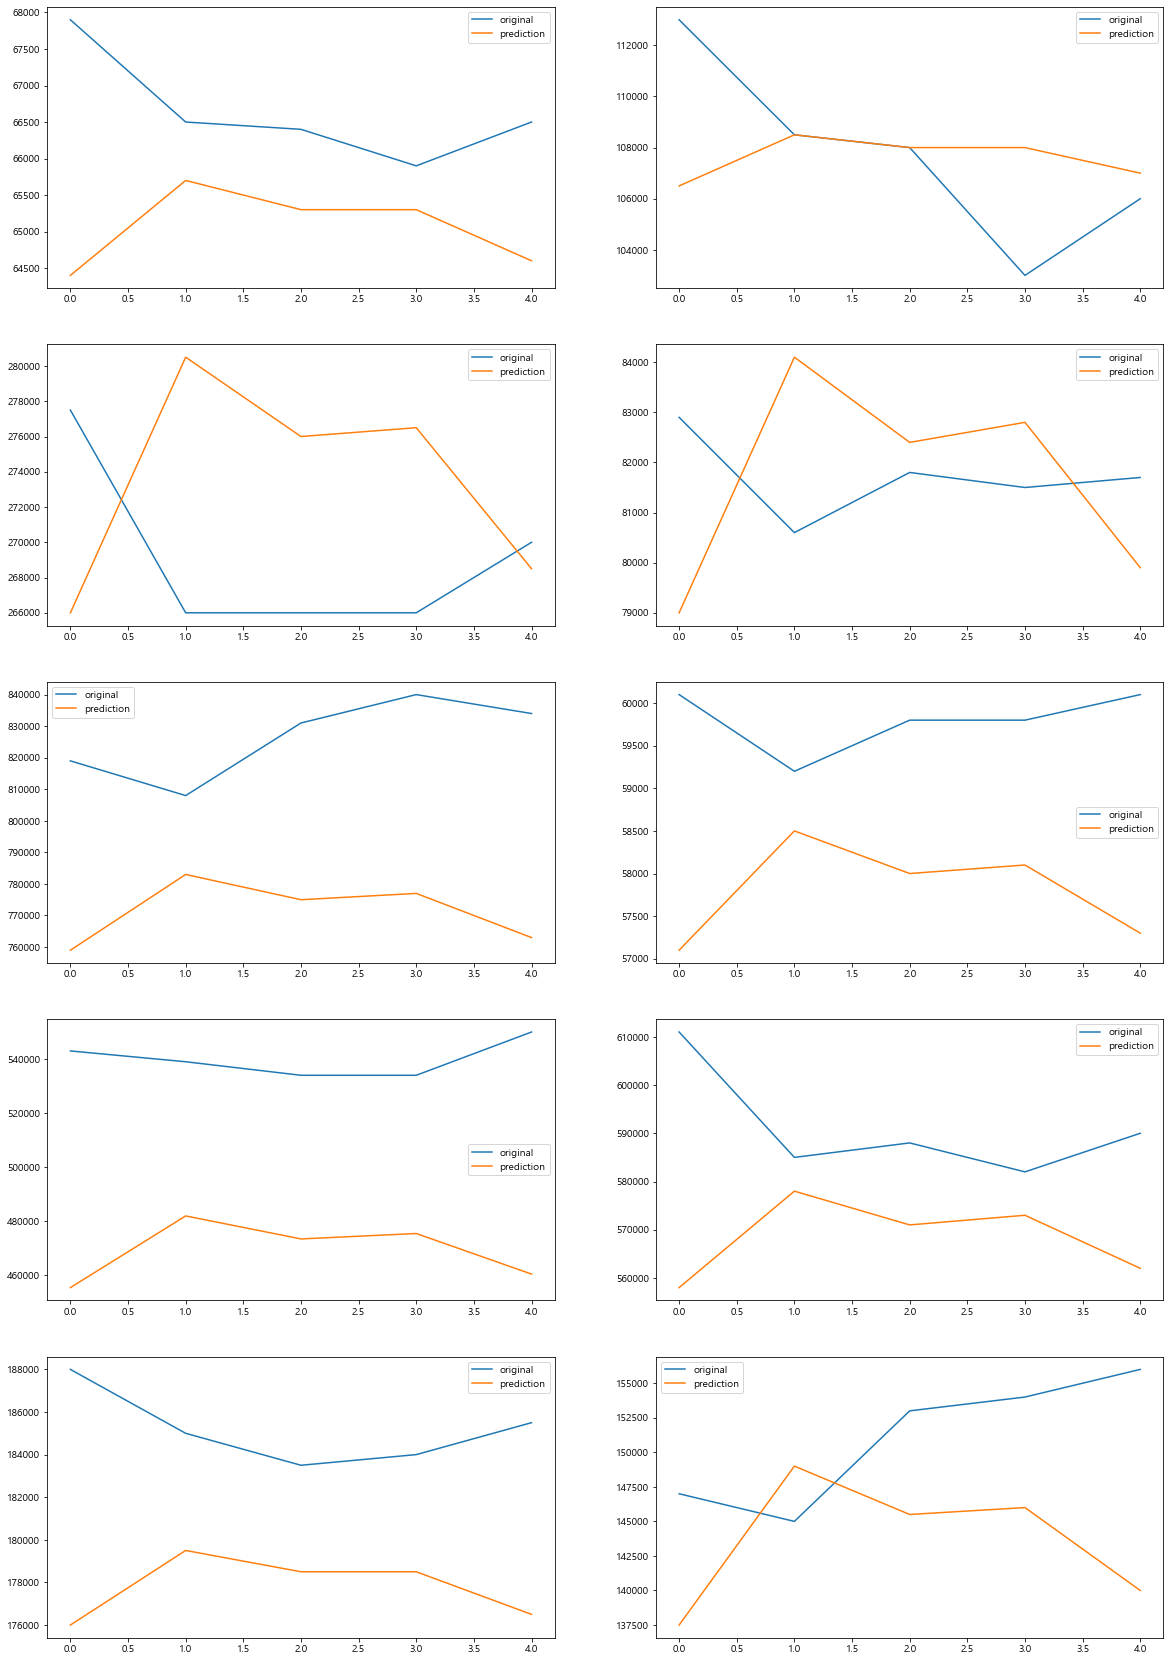

In [ ]:
err = calc_error(net, optimizer, True)